# Contrastive Activation Addition (CAA) Baseline

This notebook implements a baseline for comparison using Contrastive Activation Addition (CAA).
We use contrast pairs from the UltraFeedback dataset to generate steering vectors and observe the impact on SimPO loss.

We compare two steering methods:
1.  **Residual Stream Steering**: Computing the difference vector in the residual stream directly.
2.  **SAE Feature Steering**: Computing the difference vector in the SAE latent space and decoding it.


In [1]:
import torch
import torch.nn.functional as F
from transformer_lens import HookedTransformer
from sae_lens import SAE
from datasets import load_dataset
from tqdm.auto import tqdm
import einops
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import gc

# Add src to path
sys.path.append(os.path.abspath("../../src"))

from fsrl.simPO import apply_chat_template
from fsrl.simPO.simpo_config import SimPOConfig

# Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "gemma-2-2b-it"
SAE_RELEASE = "gemma-scope-2b-pt-res"
SAE_ID = "layer_12/width_65k/average_l0_72"
LAYER = 12
HOOK_NAME = f"blocks.{LAYER}.hook_resid_post"

print(f"Device: {DEVICE}")


Device: cuda


In [2]:
# Load Model
model = HookedTransformer.from_pretrained(
    MODEL_NAME,
    device=DEVICE,
    dtype="bfloat16"
)

# Load SAE
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release=SAE_RELEASE,
    sae_id=SAE_ID,
    device=DEVICE
)
sae = sae.to(dtype=torch.bfloat16) # Ensure dtype matches


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b-it into HookedTransformer


In [3]:
# Load Dataset
dataset_name = "princeton-nlp/llama3-ultrafeedback-armorm"
train_dataset = load_dataset(dataset_name, split="train")
eval_dataset = load_dataset(dataset_name, split="test")

# Filter/Sample
# We'll use a subset of train for generating the steering vector
num_samples = 1000
train_subset = train_dataset.shuffle(seed=42).select(range(num_samples))

print(f"Train subset size: {len(train_subset)}")
print(f"Eval dataset size: {len(eval_dataset)}")

# Chat Template
# Using the one from the config file provided in context
chat_template = "{{ bos_token }}{% if messages[0]['role'] == 'system' %}{% set system_message = messages[0]['content'] | trim + '\n\n' %}{% set messages = messages[1:] %}{% else %}{% set system_message = '' %}{% endif %}{% for message in messages %}{% if loop.index0 == 0 %}{% set content = system_message + message['content'] %}{% else %}{% set content = message['content'] %}{% endif %}{% if (message['role'] == 'assistant') %}{% set role = 'model' %}{% else %}{% set role = message['role'] %}{% endif %}{{ '<start_of_turn>' + role + '\n' + content | trim + '<end_of_turn>\n' }}{% endfor %}{% if add_generation_prompt %}{{'<start_of_turn>model\n'}}{% endif %}"

model.tokenizer.chat_template = chat_template

Train subset size: 1000
Eval dataset size: 1961


In [4]:
def get_response_activations(model, prompt, response, layer_hook):
    """
    Get the mean activation of the response tokens.
    """
    pass

def process_example(example, tokenizer):
    # Extract prompt and responses
    chosen_msgs = example['chosen'] # List of dicts
    rejected_msgs = example['rejected']
    
    # The prompt is everything except the last message
    prompt_msgs = chosen_msgs[:-1]
    chosen_response = chosen_msgs[-1]['content']
    rejected_response = rejected_msgs[-1]['content']
    
    prompt_text = tokenizer.apply_chat_template(prompt_msgs, tokenize=False, add_generation_prompt=True)
    
    # Full text
    chosen_text = prompt_text + chosen_response + "<end_of_turn>"
    rejected_text = prompt_text + rejected_response + "<end_of_turn>"
    
    return prompt_text, chosen_text, rejected_text

def get_steering_vectors(model, sae, dataset, hook_name, batch_size=8):
    # Initialize accumulators
    resid_diff_sum = None
    sae_diff_sum = None
    count = 0
    
    for i in tqdm(range(0, len(dataset), batch_size)):
        batch = dataset[i:i+batch_size]
        
        prompts = []
        chosens = []
        rejecteds = []
        
        for j in range(len(batch['chosen'])):
            p, c, r = process_example({
                'chosen': batch['chosen'][j], 
                'rejected': batch['rejected'][j]
            }, model.tokenizer)
            prompts.append(p)
            chosens.append(c)
            rejecteds.append(r)
            
        for p, c, r in zip(prompts, chosens, rejecteds):
            # Tokenize
            p_tokens = model.to_tokens(p)
            c_tokens = model.to_tokens(c)
            r_tokens = model.to_tokens(r)
            
            # Run model for chosen
            with torch.no_grad():
                _, cache_c = model.run_with_cache(c_tokens, names_filter=hook_name)
                # Use only the last token activation
                act_c = cache_c[hook_name][0, -1, :] 
                
                # Run model for rejected
                _, cache_r = model.run_with_cache(r_tokens, names_filter=hook_name)
                # Use only the last token activation
                act_r = cache_r[hook_name][0, -1, :]
                
                # Residual Diff
                diff = act_c - act_r
                
                # SAE Diff
                # Encode the last token activation
                sae_act_c = sae.encode(act_c) 
                sae_act_r = sae.encode(act_r)
                
                sae_diff = sae_act_c - sae_act_r

                # Accumulate
                if resid_diff_sum is None:
                    resid_diff_sum = torch.zeros_like(diff)
                    sae_diff_sum = torch.zeros_like(sae_diff)
                
                resid_diff_sum += diff
                sae_diff_sum += sae_diff
                count += 1
                
        # Clear cache to free memory
        torch.cuda.empty_cache()
        gc.collect()

    # Average over dataset
    avg_resid_diff = resid_diff_sum / count
    avg_sae_diff = sae_diff_sum / count
    
    return avg_resid_diff, avg_sae_diff

print("Computing steering vectors...")
# Use train_subset for steering vectors
vec_resid, vec_sae_latent = get_steering_vectors(model, sae, train_subset, HOOK_NAME)

# Decode SAE vector
vec_sae_recon = sae.decode(vec_sae_latent)
del vec_sae_latent  # Free memory

print("Vectors computed.")
print(f"Resid vector norm: {vec_resid.norm().item()}")
print(f"SAE recon vector norm: {vec_sae_recon.norm().item()}")

Computing steering vectors...


  0%|          | 0/125 [00:00<?, ?it/s]

Vectors computed.
Resid vector norm: 5.8125
SAE recon vector norm: 84.0


In [5]:
# SimPO Loss Function
def compute_simpo_loss(model, batch, beta=10.0, gamma_beta_ratio=0.5):
    # Ensure pad token is set
    if model.tokenizer.pad_token is None:
        model.tokenizer.pad_token = model.tokenizer.eos_token
    
    # Set padding side to right for easier masking
    model.tokenizer.padding_side = 'right'
    
    prompts_text = []
    chosens_text = []
    rejecteds_text = []
    
    for i in range(len(batch['chosen'])):
        p, c, r = process_example({
            'chosen': batch['chosen'][i], 
            'rejected': batch['rejected'][i]
        }, model.tokenizer)
        prompts_text.append(p)
        chosens_text.append(c)
        rejecteds_text.append(r)
        
    # Tokenize
    # prepend_bos=False because process_example adds it via template
    c_tokens = model.to_tokens(chosens_text, prepend_bos=False)
    r_tokens = model.to_tokens(rejecteds_text, prepend_bos=False)
    p_tokens = model.to_tokens(prompts_text, prepend_bos=False)
    
    # Create labels
    c_labels = c_tokens.clone()
    r_labels = r_tokens.clone()
    
    # Mask padding
    pad_token_id = model.tokenizer.pad_token_id
    c_labels[c_tokens == pad_token_id] = -100
    r_labels[r_tokens == pad_token_id] = -100
    
    # Mask prompt
    # Calculate prompt lengths (ignoring padding)
    p_lens = (p_tokens != pad_token_id).sum(dim=1)
    
    for i, p_len in enumerate(p_lens):
        c_labels[i, :p_len] = -100
        r_labels[i, :p_len] = -100
        
    with torch.no_grad():
        # Chosen
        logits_c = model(c_tokens)
        shift_logits_c = logits_c[..., :-1, :].contiguous()
        shift_labels_c = c_labels[..., 1:].contiguous()
        
        loss_fct = torch.nn.CrossEntropyLoss(reduction='none', ignore_index=-100)
        token_losses_c = loss_fct(shift_logits_c.view(-1, shift_logits_c.size(-1)), shift_labels_c.view(-1))
        token_losses_c = token_losses_c.view(c_labels.size(0), -1)
        
        # Average log prob per example
        mask_c = (shift_labels_c != -100)
        sum_loss_c = token_losses_c.sum(dim=1)
        num_tokens_c = mask_c.sum(dim=1)
        avg_log_prob_c = -sum_loss_c / num_tokens_c
        
        # Rejected
        logits_r = model(r_tokens)
        shift_logits_r = logits_r[..., :-1, :].contiguous()
        shift_labels_r = r_labels[..., 1:].contiguous()
        
        token_losses_r = loss_fct(shift_logits_r.view(-1, shift_logits_r.size(-1)), shift_labels_r.view(-1))
        token_losses_r = token_losses_r.view(r_labels.size(0), -1)
        
        mask_r = (shift_labels_r != -100)
        sum_loss_r = token_losses_r.sum(dim=1)
        num_tokens_r = mask_r.sum(dim=1)
        avg_log_prob_r = -sum_loss_r / num_tokens_r
        
        # SimPO Loss
        pi_logratios = avg_log_prob_c - avg_log_prob_r
        logits = pi_logratios - gamma_beta_ratio
        losses = -F.logsigmoid(beta * logits)
            
    return losses.mean().item()

# Evaluation Loop
def evaluate_steering(model, eval_dataset, steering_vec, hook_name, coeffs, batch_size=8):
    results = []
    
    for coeff in tqdm(coeffs, desc="Evaluating coefficients"):
        
        # Define hook
        def steering_hook(resid, hook):
            return resid + coeff * steering_vec
            
        # Add hook
        model.add_hook(hook_name, steering_hook)
        
        batch_losses = []
        try:
            for i in range(0, len(eval_dataset), batch_size):
                batch = eval_dataset[i:i+batch_size]
                loss = compute_simpo_loss(model, batch)
                batch_losses.append(loss)
            mean_loss = np.mean(batch_losses)
            print(f"Mean loss for coeff {coeff}: {mean_loss}")
            results.append(mean_loss)
        finally:
            model.reset_hooks()
            
    return results

coeffs = [0.1, 0.25, 0.5, 1, 2] 

print("Evaluating Residual Steering...")
resid_results = evaluate_steering(model, eval_dataset, vec_resid, HOOK_NAME, coeffs, batch_size=2)

print("Evaluating SAE Steering...")
sae_results = evaluate_steering(model, eval_dataset, vec_sae_recon, HOOK_NAME, coeffs, batch_size=2)

Evaluating Residual Steering...


Evaluating coefficients:   0%|          | 0/5 [00:00<?, ?it/s]

Mean loss for coeff 0.1: 5.689075172494311
Mean loss for coeff 0.25: 5.682108860618599
Mean loss for coeff 0.5: 5.67570993732604
Mean loss for coeff 1: 5.664512840372099
Mean loss for coeff 2: 5.644750616479965
Evaluating SAE Steering...


Evaluating coefficients:   0%|          | 0/5 [00:00<?, ?it/s]

Mean loss for coeff 0.1: 5.642990580878613
Mean loss for coeff 0.25: 5.580926795982804
Mean loss for coeff 0.5: 5.460134138754748
Mean loss for coeff 1: 5.386936323844451
Mean loss for coeff 2: 6.142444731473968


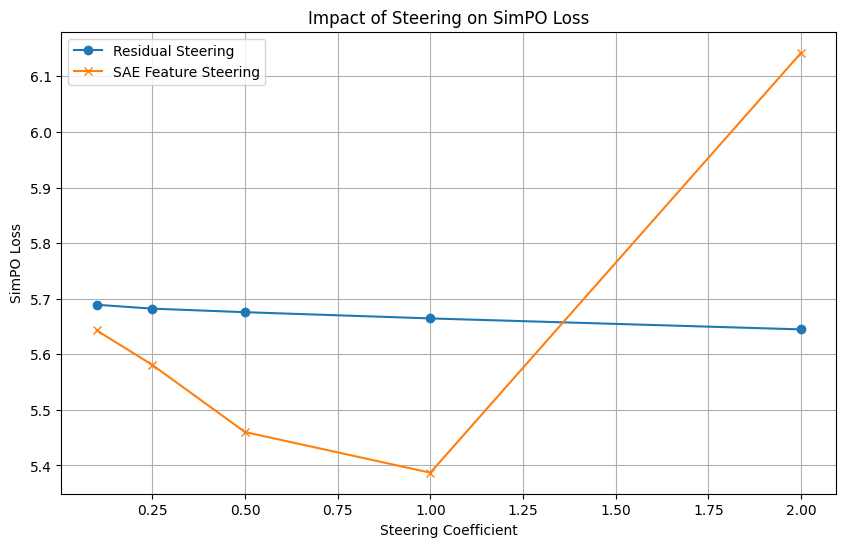

In [6]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(coeffs, resid_results, label='Residual Steering', marker='o')
plt.plot(coeffs, sae_results, label='SAE Feature Steering', marker='x')
plt.xlabel('Steering Coefficient')
plt.ylabel('SimPO Loss')
plt.title('Impact of Steering on SimPO Loss')
plt.legend()
plt.grid(True)
plt.show()
